<a href="https://colab.research.google.com/github/jjungmini/pv-forecasting/blob/main/LSTM/pv_lstm_%EC%A0%84%EC%B2%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
# 데이터 로딩
df = pd.read_excel('pvdata.xlsx', sheet_name=3)

# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['solarpower'] = target_scaler.fit_transform(df[['solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외
correlation_matrix = df.drop(columns=['Date', 'solarpower']).corr()

# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'solarpower'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

In [3]:
# 시계열 데이터를 위해 시간 순서대로 정렬
df = df.sort_values(by='Date')

# 4월을 기준으로 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2023-04-01']
test = df[df['Date'] >= '2023-04-01']

# 훈련 데이터에서 특성과 타겟 변수 선택
X_train, y_train = train.drop(columns=['Date', 'solarpower']), train['solarpower']

# LSTM에 입력할 형태로 데이터 변환
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))

In [4]:
# 하이퍼파라미터 설정
units = 100           # LSTM 뉴런 수
activation = 'tanh'   # 활성화 함수
recurrent_activation = 'hard_sigmoid'  # 순환 활성화 함수
use_bias = True       # 바이어스 사용 여부
kernel_initializer = 'glorot_uniform'  # 가중치 행렬 초기화 방법
recurrent_initializer = 'orthogonal'   # 순환 가중치 행렬 초기화 방법
bias_initializer = 'zeros'             # 바이어스 초기화 방법
unit_forget_bias = True                # forget 게이트의 바이어스 초기화 여부
dropout = 0.2         # 입력 유닛 드롭아웃 비율
recurrent_dropout = 0.2  # 순환 상태 드롭아웃 비율
return_sequences = False  # 출력이 모든 시퀀스에 대한 출력인지 여부
return_state = False      # 출력에 상태 정보 포함 여부
go_backwards = False      # 입력 시퀀스를 역방향으로 처리 여부
stateful = False          # 상태가 배치 간에 유지 여부
unroll = False            # 네트워크를 풀링하여 더 빠르게 실행 여부

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(units=units,
               activation=activation,
               recurrent_activation=recurrent_activation,
               use_bias=use_bias,
               kernel_initializer=kernel_initializer,
               recurrent_initializer=recurrent_initializer,
               bias_initializer=bias_initializer,
               unit_forget_bias=unit_forget_bias,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               return_sequences=return_sequences,
               return_state=return_state,
               go_backwards=go_backwards,
               stateful=stateful,
               unroll=unroll,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='linear', kernel_initializer='he_normal'))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')

In [5]:
# 5-fold 교차 검증 수행
tscv = TimeSeriesSplit(n_splits=10)
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

from keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 훈련
model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=24,
          validation_data=(X_val_fold, y_val_fold), verbose=2,
          callbacks=[early_stopping])


Epoch 1/30
1079/1079 - 11s - loss: 0.0086 - val_loss: 0.0113 - 11s/epoch - 10ms/step
Epoch 2/30
1079/1079 - 6s - loss: 0.0056 - val_loss: 0.0096 - 6s/epoch - 6ms/step
Epoch 3/30
1079/1079 - 6s - loss: 0.0052 - val_loss: 0.0101 - 6s/epoch - 6ms/step
Epoch 4/30
1079/1079 - 6s - loss: 0.0049 - val_loss: 0.0094 - 6s/epoch - 5ms/step
Epoch 5/30
1079/1079 - 7s - loss: 0.0048 - val_loss: 0.0084 - 7s/epoch - 7ms/step
Epoch 6/30
1079/1079 - 6s - loss: 0.0045 - val_loss: 0.0080 - 6s/epoch - 5ms/step
Epoch 7/30
1079/1079 - 7s - loss: 0.0042 - val_loss: 0.0075 - 7s/epoch - 7ms/step
Epoch 8/30
1079/1079 - 5s - loss: 0.0040 - val_loss: 0.0082 - 5s/epoch - 5ms/step
Epoch 9/30
1079/1079 - 7s - loss: 0.0036 - val_loss: 0.0065 - 7s/epoch - 7ms/step
Epoch 10/30
1079/1079 - 6s - loss: 0.0034 - val_loss: 0.0071 - 6s/epoch - 5ms/step
Epoch 11/30
1079/1079 - 11s - loss: 0.0033 - val_loss: 0.0071 - 11s/epoch - 11ms/step
Epoch 12/30
1079/1079 - 8s - loss: 0.0032 - val_loss: 0.0062 - 8s/epoch - 8ms/step
Epoch 1

In [6]:
# 테스트 데이터에 대한 예측 수행
X_test, y_test = test.drop(columns=['Date', 'solarpower']), test['solarpower']
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_pred = model.predict(X_test)

# 예측된 값을 원래 스케일로 역변환
y_pred = target_scaler.inverse_transform(y_pred)
y_test = target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

23/23 [==============================] - 0s 3ms/step


In [7]:
# 평가 지표 계산
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

평균 제곱 오차 (MSE): 541.0680935206065
평균 절대 오차 (MAE): 17.80443915033122
결정 계수 (R2): 0.9517317735152594
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 23.26087043772452


<ipython-input-7-1a7e69b89236>:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


In [12]:
# 평가지표를 데이터프레임으로 저장
evaluations = pd.DataFrame({'variables': "전체", 'MSE':mse, 'MAE':mae, 'R2':r2, 'MAPE':mape, 'RMSE':rmse}, index=[0])
# 엑셀 파일로 저장
evaluations.to_excel('evaluations_전체.xlsx', index=False)

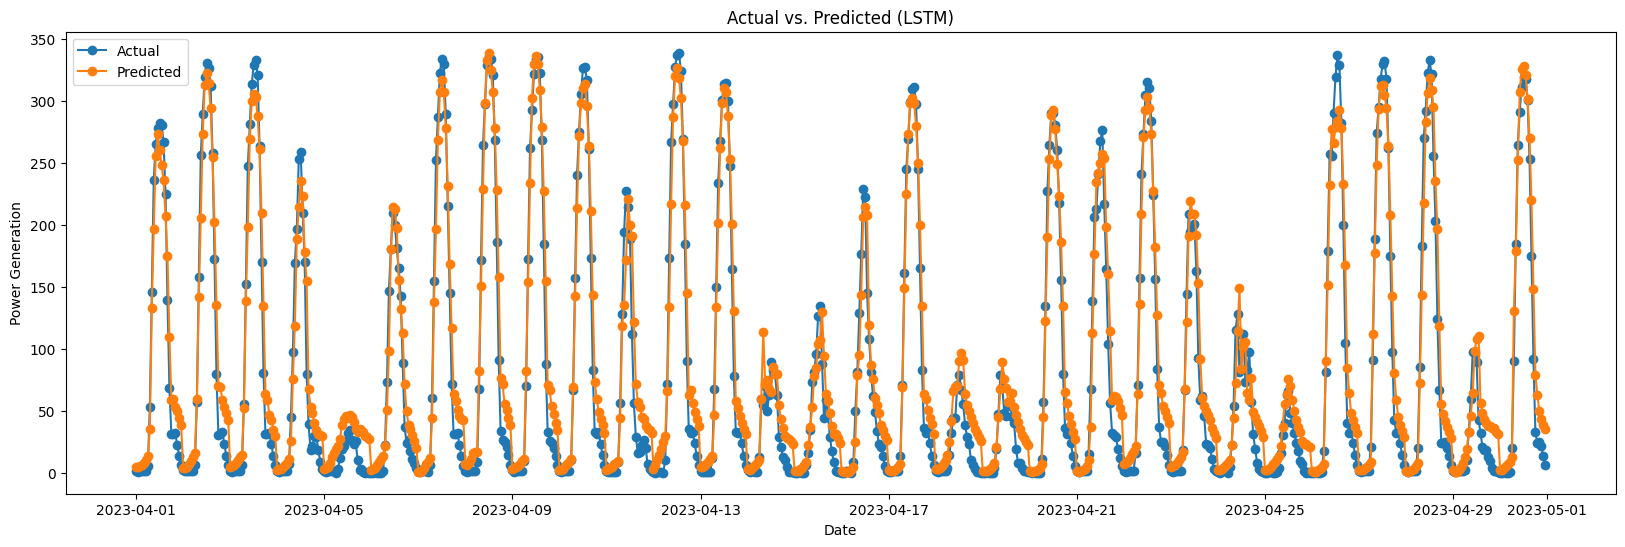

In [9]:
# 실제 값과 예측값 시각화
plt.figure(figsize=(20, 6))
plt.plot(test['Date'], y_test, label='Actual', marker='o')
plt.plot(test['Date'], y_pred, label='Predicted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Predicted (LSTM)')
plt.legend()
plt.show()

In [10]:
# 예측값을 데이터프레임으로 변환
predictions_df = pd.DataFrame({'Date': test['Date'], 'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

# 엑셀 파일로 저장
predictions_df.to_excel('predictions_전체.xlsx', index=False)